In [62]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [15]:
# build the dataset
import random
block_size = 3  # context length: how many characters do we take to predict the next one?


def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte = build_dataset(words[n2:])     # 10%

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [ ]:
# MLP revisited
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 200  # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)  # for reproducibility
C = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / \
    (n_embd * block_size**0.5)  # 0.2 n_embd = 10 and block size is 3
b1 = torch.randn(n_hidden,                        generator=g) * .01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))


parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))  # number of parameters in total
for p in parameters:
    p.requires_grad = True

12297


In [119]:
hpreact.shape

torch.Size([32, 200])

In [120]:
hpreact.mean(0, keepdim=True)

tensor([[-1.4901e-08, -3.7253e-09, -2.2352e-08, -2.6077e-08,  0.0000e+00,
         -2.9802e-08, -9.3132e-10,  0.0000e+00, -2.2352e-08,  1.4901e-08,
          1.1176e-08,  4.4703e-08,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          4.4703e-08,  1.1176e-08,  0.0000e+00, -1.4901e-08,  6.7055e-08,
          2.9802e-08,  7.4506e-09, -1.8626e-08, -2.2352e-08, -7.4506e-09,
          7.4506e-09,  3.7253e-09,  1.4435e-08, -2.2352e-08, -1.8626e-08,
         -2.2352e-08,  0.0000e+00,  7.4506e-09,  0.0000e+00, -1.8626e-08,
          3.7253e-09,  4.0047e-08,  1.1176e-08,  0.0000e+00, -7.4506e-09,
         -2.9802e-08, -1.1921e-07,  1.4901e-08,  7.4506e-09,  0.0000e+00,
         -7.4506e-09,  0.0000e+00,  4.4703e-08, -7.4506e-09,  0.0000e+00,
         -6.7055e-08, -2.9802e-08,  1.4901e-08, -1.4901e-08, -3.7253e-08,
          0.0000e+00,  3.3528e-08,  7.4506e-09, -4.4703e-08,  5.0291e-08,
         -3.3528e-08,  0.0000e+00, -5.5879e-08, -2.2352e-08,  0.0000e+00,
          1.4901e-08,  1.8626e-09, -1.

In [121]:
hpreact.mean

<function Tensor.mean>

In [134]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch x,y

    # forward pass
    emb = C[Xb]  # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1)  # concatenate the vectors
    hpreact = embcat @ W1 + b1  # hidden layer pre-activation
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)

    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact)  # hidden layer
    logits = h @ W2 + b2  # output layer
    loss = F.cross_entropy(logits, Yb)  # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    lr = 0.1 if i < 100000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:  # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 2.1079
  10000/ 200000: 2.0244
  20000/ 200000: 1.8644
  30000/ 200000: 2.1411
  40000/ 200000: 2.3181
  50000/ 200000: 1.9069
  60000/ 200000: 1.8054
  70000/ 200000: 1.8995
  80000/ 200000: 1.9772
  90000/ 200000: 2.0247
 100000/ 200000: 1.5039
 110000/ 200000: 1.9769
 120000/ 200000: 2.0083
 130000/ 200000: 1.7403
 140000/ 200000: 2.3908
 150000/ 200000: 2.1313
 160000/ 200000: 2.1447
 170000/ 200000: 1.8136
 180000/ 200000: 2.1710
 190000/ 200000: 2.3064


In [123]:
logits[0]

tensor([-4.3283,  1.7723,  0.7964,  0.7222,  0.9429,  0.9525, -0.0796, -0.1515,
         0.2179, -0.4916,  1.2971,  1.5049,  0.8159,  1.4928,  0.5050, -0.6588,
         0.1455, -1.9739,  0.9172,  1.0858,  1.1703, -2.2315, -1.1007, -0.6824,
        -2.3011, -0.4781,  0.2616], grad_fn=<SelectBackward0>)

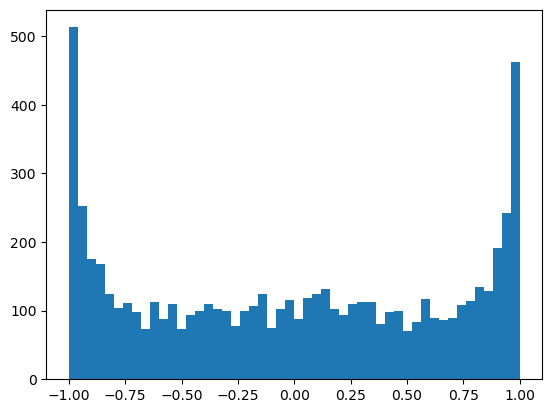

In [124]:
plt.hist(h.view(-1).tolist(), 50)
plt.show()

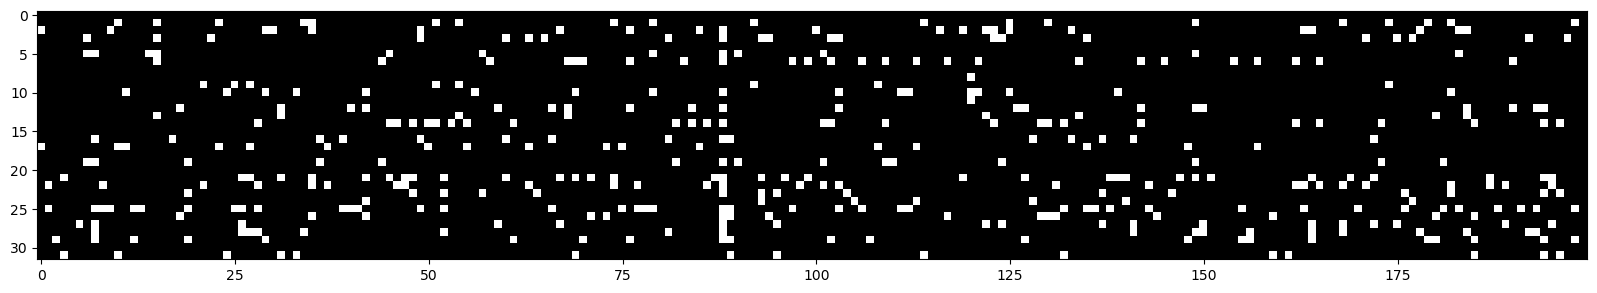

In [125]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')
plt.show()

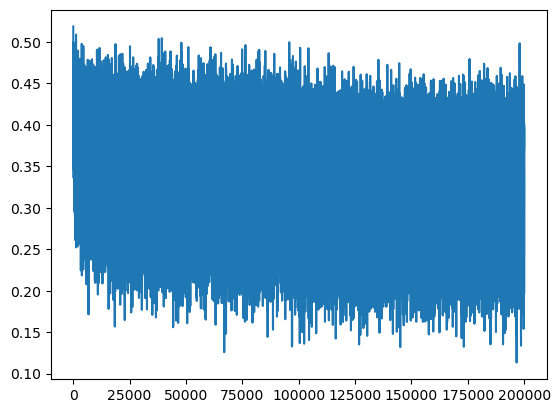

In [126]:
plt.plot(lossi)
plt.show()

In [135]:
# calibrate the batch norm at the end of training

with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measure the mean and std dev over the entire training set one single time
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [138]:
bnstd

tensor([[2.8329, 2.4941, 2.3944, 2.7456, 2.1586, 2.6829, 2.8849, 3.0637, 2.6007,
         2.5813, 3.0776, 2.9179, 2.4139, 2.4207, 2.1237, 3.0636, 2.4843, 2.2479,
         2.5795, 2.7042, 2.5401, 2.6413, 2.1804, 2.5711, 2.3231, 2.5160, 2.6658,
         2.8244, 3.0527, 2.6187, 2.4605, 2.5883, 2.8853, 2.4456, 2.4342, 2.9919,
         2.5714, 2.6406, 2.6860, 2.3819, 2.1357, 2.4973, 3.0202, 2.2531, 2.5021,
         3.1003, 2.6189, 2.8520, 2.5325, 2.7562, 2.4057, 2.5071, 2.8905, 2.4640,
         2.4795, 2.7126, 2.4361, 2.2955, 2.6151, 2.4327, 2.6966, 2.4671, 2.8308,
         2.8654, 2.3431, 2.4881, 2.3979, 2.8657, 2.6423, 2.8135, 2.6831, 2.8481,
         2.1446, 2.5015, 2.4406, 2.3817, 2.6146, 2.6829, 2.6431, 2.7517, 2.3905,
         2.8926, 2.5526, 2.2275, 2.6986, 2.7007, 2.4844, 2.3967, 2.9623, 3.3539,
         2.4403, 2.3273, 2.5908, 2.5751, 2.3300, 2.6508, 2.3267, 2.4625, 2.4342,
         2.4201, 2.3135, 2.7243, 2.5102, 2.7964, 2.1702, 2.5003, 2.3421, 2.3138,
         2.3878, 2.4278, 2.5

In [139]:
bnstd_running

tensor([[2.7962, 2.4582, 2.3425, 2.7182, 2.1375, 2.6491, 2.8744, 3.0440, 2.5596,
         2.5685, 3.0646, 2.8887, 2.3888, 2.3936, 2.0993, 3.0320, 2.4742, 2.2314,
         2.5536, 2.6785, 2.5148, 2.6003, 2.1763, 2.5364, 2.3026, 2.5028, 2.6274,
         2.7869, 3.0225, 2.5885, 2.4304, 2.5521, 2.8609, 2.4388, 2.3947, 2.9777,
         2.5432, 2.6124, 2.6822, 2.3581, 2.0913, 2.4758, 2.9899, 2.2298, 2.4723,
         3.0724, 2.5908, 2.8106, 2.5167, 2.7384, 2.3605, 2.4815, 2.8554, 2.4452,
         2.4621, 2.6711, 2.4090, 2.2631, 2.5883, 2.4089, 2.6626, 2.4477, 2.8091,
         2.8332, 2.3074, 2.4715, 2.3738, 2.8235, 2.6155, 2.7770, 2.6540, 2.8191,
         2.1310, 2.4534, 2.4053, 2.3442, 2.5972, 2.6648, 2.6261, 2.7364, 2.3584,
         2.8311, 2.5342, 2.1987, 2.6540, 2.6689, 2.4420, 2.3770, 2.9450, 3.3341,
         2.4104, 2.3182, 2.5689, 2.5499, 2.3159, 2.6246, 2.2999, 2.4435, 2.3957,
         2.3925, 2.2870, 2.6760, 2.4865, 2.7683, 2.1384, 2.4717, 2.3103, 2.2633,
         2.3605, 2.4072, 2.4

In [ ]:
@torch.no_grad()  # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]  # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1)  # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1  # + b1
    u = hpreact.mean(0, keepdim=True)  # mini-batch mean
    # hpreact = bngain * (hpreact - u)/hpreact.std(0, keepdim=True) + bnbias
    hpreact = bngain * (hpreact-bnmean) / bnstd + bnbias
    h = torch.tanh(hpreact)  # (N, n_hidden)
    logits = h @ W2 + b2  # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


split_loss('train')
split_loss('val')

train 2.0589189529418945
val 2.1037869453430176


tensor(-0.0080) tensor(1.0008)
tensor(0.0002) tensor(1.0100)


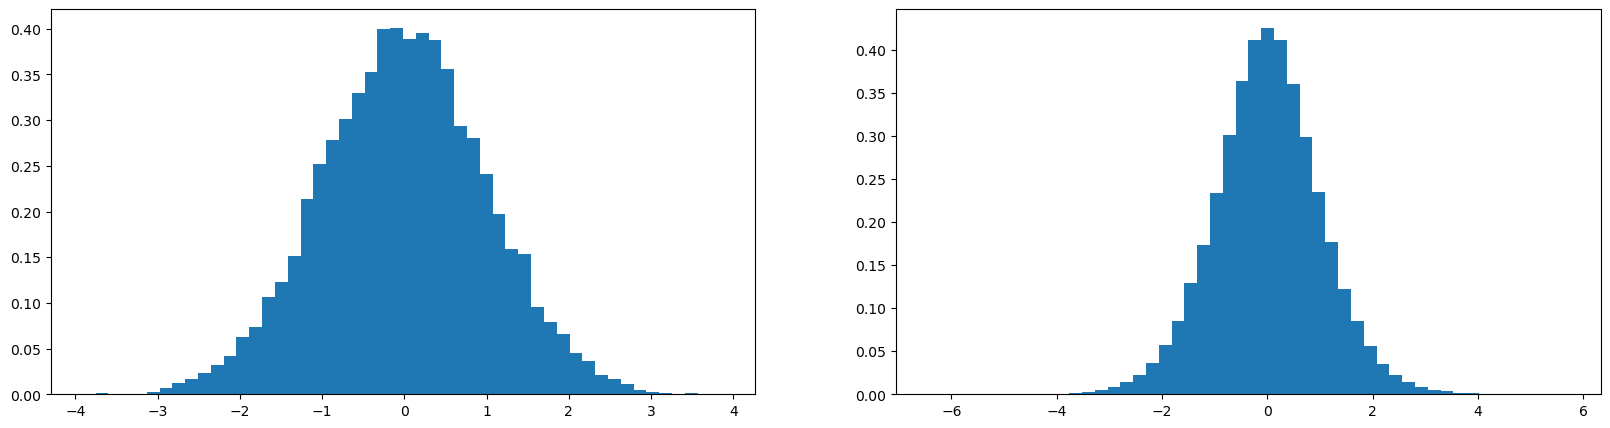

In [128]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5

y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())

plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)

plt.show()

In [117]:
-torch.tensor(1/27).log()

tensor(3.2958)